# Predictive Modeling - Decision Tree

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn import tree
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import GridSearchCV
%matplotlib inline
sns.set(style="darkgrid")

# Function for displaying all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
            
# Function for plotting the confusion matrix
def plot_confusion_matrix(cnf_mtx, model_name='Model'):
    fig, ax = plt.subplots(figsize=(6, 6))
    title = model_name + ' Confusion Matrix'
    ax = sns.heatmap(cnf_mtx, annot=True, fmt="d", cbar=False, cmap='Blues', square=True)
    ax = ax.set(title=title, xlabel='Predicted Label', ylabel='True Label')

# Function for plotting ROC with AUC
def plot_roc_curve(actuals, probs, model_name='Model'):
    """ Function takes a8998l,llctual Y labels and prediciton probabilities for 
        both classes. Function uses these to plot ROC-curves and AUC.
    """
    # Calculating true and false positive rates
    fpr, tpr, _ = roc_curve(actuals.values.ravel(), probs[:,1])
    
    # Calculating AUC
    auc = roc_auc_score(actuals.values.ravel(), probs[:,1])
    
    # Create plot legend with AUC metric
    label = model_name + ', AUC: %.3f' % auc
    
    # Plot the roc curve for the model
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
# Function for plotting the training AUC vs. validation AUC
def plot_train_vs_valid_AUC(x_label, x_values, train_AUC_values, valid_AUC_values):
    line1, = plt.plot(x_values, train_AUC_values, 'b', label="Train AUC")
    line2, = plt.plot(x_values, valid_AUC_values, 'r', label="Validation AUC")

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

    plt.ylabel("AUC score")
    plt.xlabel(x_label)
    plt.show()    

# Baseline Model

In [4]:
# Reading data 
trainX = pd.read_csv('../data/trainX.csv')
trainY = pd.read_csv('../data/trainY.csv')
validX = pd.read_csv('../data/validX.csv')
validY = pd.read_csv('../data/validY.csv')

print(trainX.shape, trainY.shape, validX.shape, validY.shape)
display_all(trainX.head(10).transpose())

(31647, 48) (31647, 1) (6782, 48) (6782, 1)


,0,1,2,3,4,5,6,7,8,9
age,36,56,46,41,38,33,43,61,36,47
default,0,0,0,0,0,0,0,0,0,0
balance,0,196,0,3426,0,839,429,938,2415,1152
housing,0,0,1,0,1,1,1,0,1,0
loan,0,0,0,0,0,0,0,0,0,0
day,17,19,5,1,20,28,27,15,22,7
duration,153,312,83,302,90,469,222,212,73,260
campaign,4,3,2,1,1,3,4,2,1,13
pdays,-1,-1,-1,119,-1,-1,-1,92,86,-1
previous,0,0,0,5,0,0,0,5,4,0


In [5]:
# training the classifier

clf = tree.DecisionTreeClassifier()
clf = clf.fit(trainX, trainY)

# prediction
predY = clf.predict(validX)
probs = clf.predict_proba(validX)

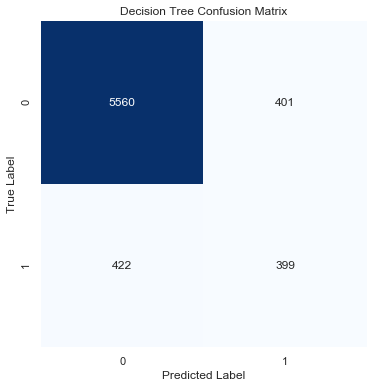

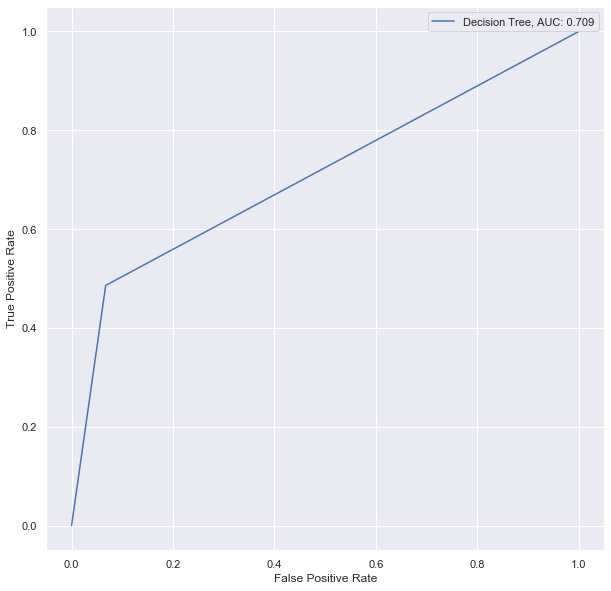

In [6]:
# model evaluation

# confusion matrix
cm = confusion_matrix(validY, predY)
plot_confusion_matrix(cm, model_name='Decision Tree')

# ROC with AUC
plot_roc_curve(validY, probs, model_name='Decision Tree')


# Trying different Parameters on Baseline Model

Trying different values of max_depth, min_samples_split and min_samples_leaf parameters individually and evaluating the effects using AUC score to find a range where to search for the optimal values.

More information on the parameters can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

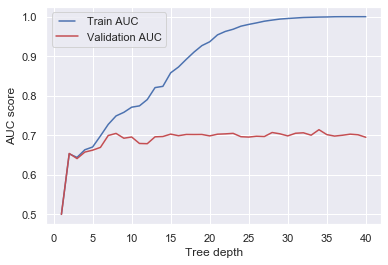

In [7]:
# Tuning the max_depth

max_depths = np.linspace(1, 40, 40, endpoint=True)
train_results = []
valid_results = []
for max_depth in max_depths:
   clf = tree.DecisionTreeClassifier(max_depth=max_depth)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   valid_results.append(roc_auc)

plot_train_vs_valid_AUC("Tree depth", max_depths, train_results, valid_results)

The figure shows that the model overfits for large depth values. The tree predicts all of the train data with high depths but fails to generalize the findings for new data. The parameter value should be chosen somewhere between 0 and 15 to avoid overfitting.

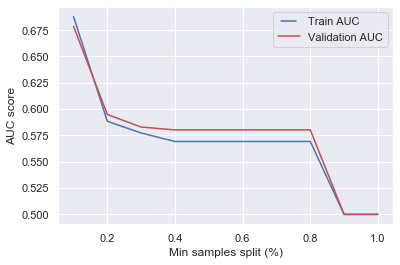

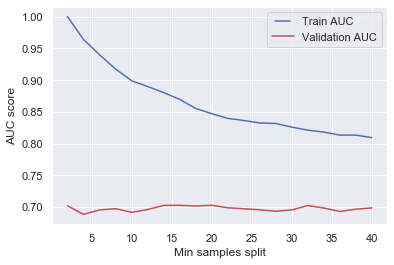

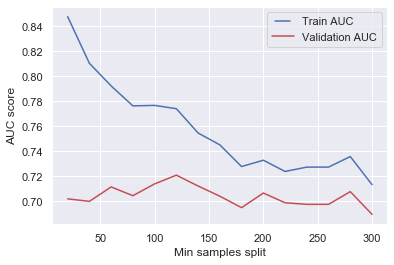

In [8]:
# Tuning the min_samples_split

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
valid_results = []
for min_samples_split in min_samples_splits:
   clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples split (%)", min_samples_splits, train_results, valid_results)

min_samples_splits = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
train_results = []
valid_results = []
for min_samples_split in min_samples_splits:
   clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples split", min_samples_splits, train_results, valid_results)

min_samples_splits = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]
train_results = []
valid_results = []
for min_samples_split in min_samples_splits:
   clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples split", min_samples_splits, train_results, valid_results)

The figures shows that when increasing the min_samples_split to maximum and therefore considering 100% of samples at each node the model's performance weakens as it can't learn enough from the data. This parameter shouldn't be tuned very high.

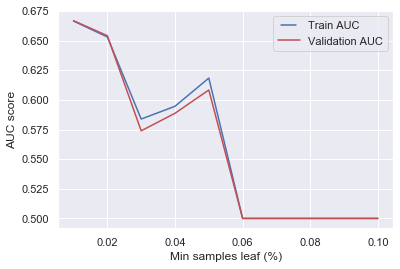

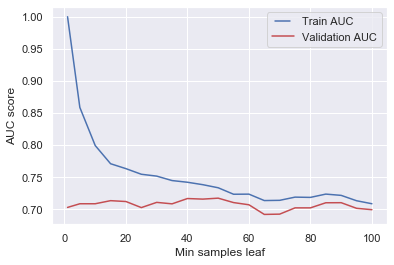

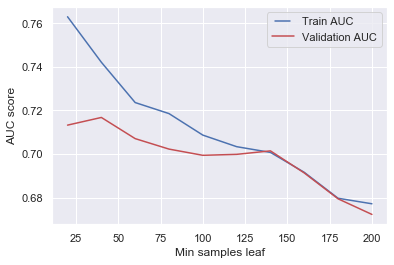

In [9]:
# Tuning the min_samples_leaf

min_samples_leafs = np.linspace(0.01, 0.1, 10, endpoint=True)
train_results = []
valid_results = []
for min_samples_leaf in min_samples_leafs:
   clf = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples leaf (%)", min_samples_leafs, train_results, valid_results)

min_samples_leafs = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
train_results = []
valid_results = []
for min_samples_leaf in min_samples_leafs:
   clf = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples leaf", min_samples_leafs, train_results, valid_results)

min_samples_leafs = [20,40,60,80,100,120,140,160,180,200]
train_results = []
valid_results = []
for min_samples_leaf in min_samples_leafs:
   clf = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   clf.fit(trainX, trainY)
   train_pred = clf.predict(trainX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   valid_pred = clf.predict(validX)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(validY, valid_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   valid_results.append(roc_auc)
    
plot_train_vs_valid_AUC("Min samples leaf", min_samples_leafs, train_results, valid_results)

The figures show that really high values for min_samples_leaf causes underfitting, and the optimal value should be under 100.

# Baseline model with Balanced Dataset

In [10]:
# Reading data 
balanced_trainX = pd.read_csv('../data/balanced_trainX.csv')
balanced_trainY = pd.read_csv('../data/balanced_trainY.csv')
validX = pd.read_csv('../data/validX.csv')
validY = pd.read_csv('../data/validY.csv')

print(balanced_trainX.shape, balanced_trainY.shape, validX.shape, validY.shape)
display_all(balanced_trainX.head(10).transpose())

(55912, 48) (55912, 1) (6782, 48) (6782, 1)


,0,1,2,3,4,5,6,7,8,9
age,36,56,46,41,38,33,43,61,36,47
default,0,0,0,0,0,0,0,0,0,0
balance,0,196,0,3426,0,839,429,938,2415,1152
housing,0,0,1,0,1,1,1,0,1,0
loan,0,0,0,0,0,0,0,0,0,0
day,17,19,5,1,20,28,27,15,22,7
duration,153,312,83,302,90,469,222,212,73,260
campaign,4,3,2,1,1,3,4,2,1,13
pdays,-1,-1,-1,119,-1,-1,-1,92,86,-1
previous,0,0,0,5,0,0,0,5,4,0


In [11]:
# training the classifier

clf = tree.DecisionTreeClassifier()
clf = clf.fit(balanced_trainX, balanced_trainY)

#prediction
predY = clf.predict(validX)
probs = clf.predict_proba(validX)

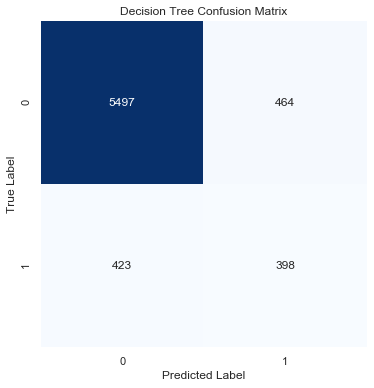

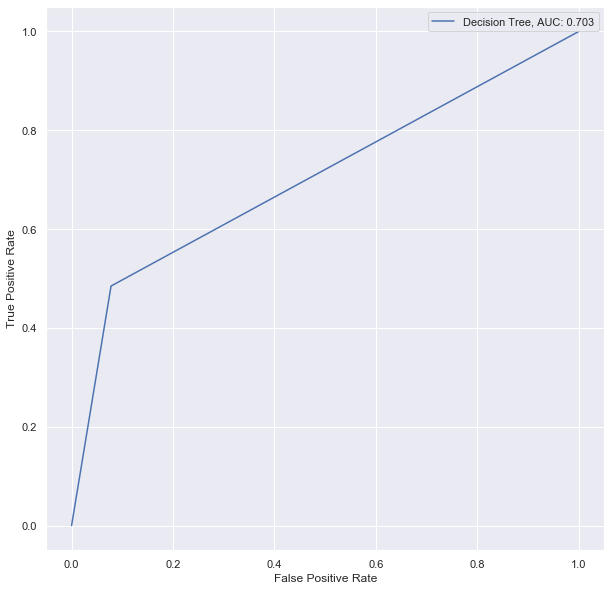

In [12]:
# model evaluation

# condusion matrix
cm = confusion_matrix(validY, predY)
plot_confusion_matrix(cm, model_name='Decision Tree')

# ROC with AUC
plot_roc_curve(validY, probs, model_name='Decision Tree')


Because the scores of the baseline model with the balanced dataset doesn't differ much from the scores with the oversampled dataset, hyperparameter tuning should be done with both datasets.

# Hyperparameter tuning

## Tuning the hyperparameters with the oversampled dataset.

In [13]:
# Setting the ranges there to look for tuned parameter values
parameters = {'max_depth': [2,4,8,12,15,20], 'min_samples_split': [2,5,12,20,30,40,60,120], 'min_samples_leaf': [1,5,10,20,30,40,50,60,80]}

# Initiate Grid Search with the default 5-fold cross-validation
search = GridSearchCV(tree.DecisionTreeClassifier(), parameters, scoring='roc_auc')
search.fit(trainX, trainY)

# Print out best score and corresponding paremeter values
print('Best score: ' + '%.3f' % search.best_score_ + ' with hyperparameters: ' + '%s' % search.best_params_)

Best score: 0.906 with hyperparameters: {'max_depth': 15, 'min_samples_leaf': 60, 'min_samples_split': 30}


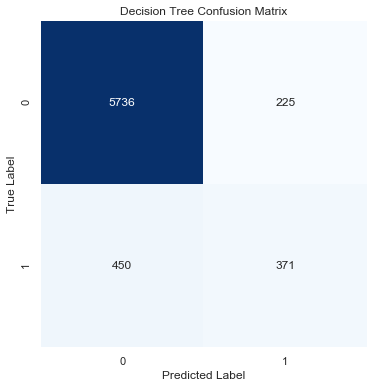

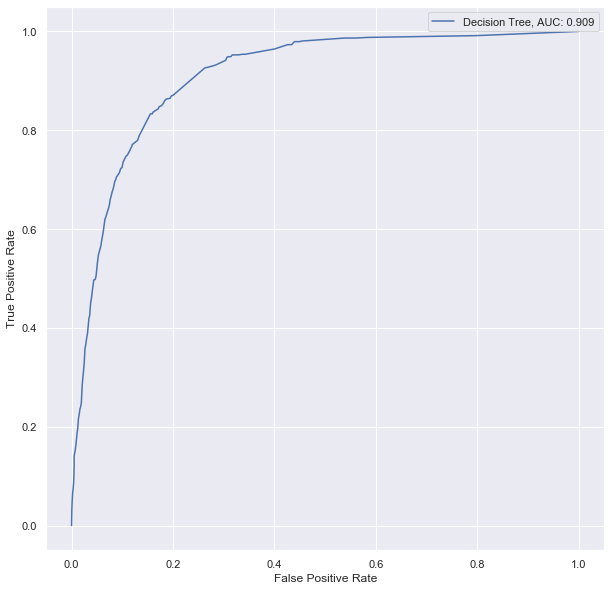

In [16]:
# Testing the model with tuned hyperparameters on validation set

clf = tree.DecisionTreeClassifier(max_depth = 15,  min_samples_leaf = 60, min_samples_split = 30)
clf = clf.fit(trainX, trainY)
predY = clf.predict(validX)
probs = clf.predict_proba(validX)


cm = confusion_matrix(validY, predY)
plot_confusion_matrix(cm, model_name='Decision Tree')

plot_roc_curve(validY, probs, model_name='Decision Tree')

The overall performance of the model is much better with the tuned parameters (AUC score raised from 0.7 to 0.9), although the untuned model seemed to recognize the class with label 1 slightly better.

## Tuning the parameters with the balanced dataset.

In [17]:
# Setting the ranges there to look for tuned parameter values
parameters = {'max_depth': [2,4,8,12,15,20], 'min_samples_split': [2,5,12,20,30,40,60,120], 'min_samples_leaf': [1,5,10,20,30,40,50,60,80]}

# Initiate Grid Search with the default 5-fold cross-validation
search = GridSearchCV(tree.DecisionTreeClassifier(), parameters, scoring='roc_auc')
search.fit(balanced_trainX, balanced_trainY)

# Print out best score and corresponding paremeter values
print('Best score: ' + '%.3f' % search.best_score_ + ' with hyperparameters: ' + '%s' % search.best_params_)

Best score: 0.973 with hyperparameters: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 120}


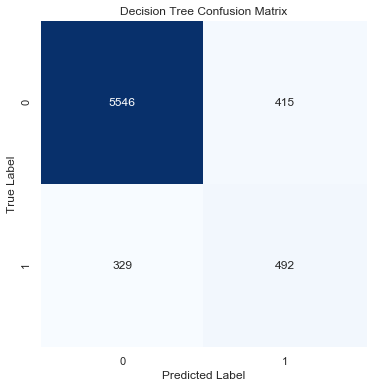

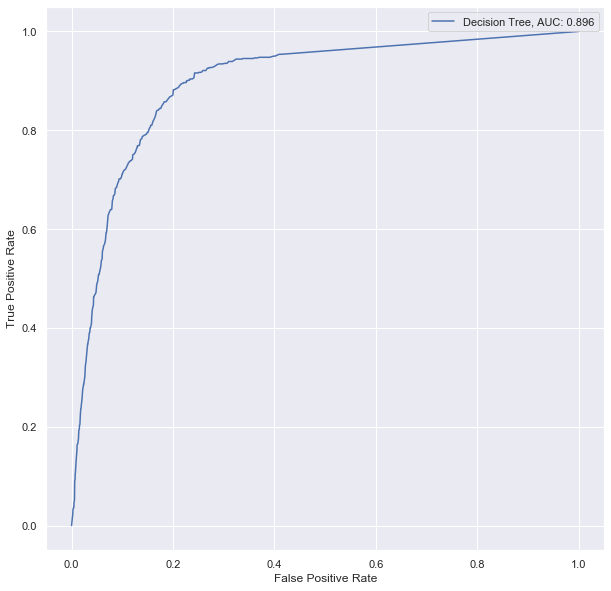

In [20]:
# Testing model with tuned hyperparameters on validation set

clf = tree.DecisionTreeClassifier(max_depth = 20,  min_samples_leaf = 10, min_samples_split = 120)
clf = clf.fit(balanced_trainX, balanced_trainY)
predY = clf.predict(validX)
probs = clf.predict_proba(validX)


cm = confusion_matrix(validY, predY)
plot_confusion_matrix(cm, model_name='Decision Tree')

plot_roc_curve(validY, probs, model_name='Decision Tree')

The best performance seems to be achieved with the tuned parameters on the balanced dataset. The model achieved an AUC score of 0.896 and the ability to recongize the class with label 1 is much better than with the other options.